# famCHESS Modeling EDA

Kendra Wyant

## Notes

This script reads in the processed famCHESS data (see `eda_cleaning.qmd`) and performs modeling checks for assumptions, covariates, mediators, and moderators.

## Setup

In [ ]:
options(conflicts.policy = "depends.ok")
suppressMessages(library(tidyverse))
suppressMessages(library(janitor))
library(Matrix, exclude = c("expand", "pack", "unpack"))
library(lme4)
theme_set(theme_classic()) 

devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

## Data

In [ ]:
data <- read_csv(here::here(path_data, "famchess_data_ana.csv"),
                 show_col_types = FALSE) |> 
  mutate(across(where(is.character), ~as.factor(.x))) |> 
  glimpse()


Rows: 928
Columns: 38
$ study_id                 <fct> 100FAM, 100FAM, 100FAM, 100PT, 100PT, 100PT, …
$ dyad                     <fct> Partner, Partner, Partner, Patient, Patient, …
$ arm                      <fct> ACHESS, ACHESS, ACHESS, ACHESS, ACHESS, ACHES…
$ group                    <fct> ACHESS Partner, ACHESS Partner, ACHESS Partne…
$ time                     <fct> 4 Month, 8 Month, 12 Month, 12 Month, 4 Month…
$ comments                 <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ gender                   <fct> non-male, non-male, non-male, male, male, mal…
$ age                      <dbl> 55, 55, 55, 56, 56, 56, 62, 62, 62, 66, 66, 6…
$ edu                      <fct> "Some college or 2 year degree", "Some colleg…
$ income                   <fct> "$35,000 to $49,999", "$35,000 to $49,999", "…
$ partner_relationship     <fct> Romantic partner/spouse, Romantic partner/spo…
$ employment               <fct> Yes, Yes, Yes, Yes, Yes, Yes, No, No, No, No,…
$ days_app_use    

Center baseline values of outcomes

In [ ]:
data <- data |> 
  mutate(hdd_0 = hdd_0 - mean(hdd_0, na.rm = TRUE),
         pda_0 = pda_0 - mean(pda_0, na.rm = TRUE),
         oq45_0 = oq45_0 - mean(oq45_0, na.rm = TRUE),
         relationsatisf_0 = relationsatisf_0 - mean(relationsatisf_0, na.rm = TRUE),
         abuse_0 = abuse_0 - mean(abuse_0, na.rm = TRUE))


Center time at the end of the intervention period (8 months).

In [ ]:
data <- data |> 
  mutate(time = factor(time, levels = c("4 Month", "8 Month", "12 Month")),
         time_c = as.numeric(time) - 2)


Center non-binary covariates

In [ ]:
data <- data |> 
  mutate(age_c = age - mean(age, na.rm = TRUE),
         edu = factor(edu, levels = c("8th grade or less", 
                                      "Some high school, but did not graduate",
                                      "High school graduate or GED",
                                      "Some college or 2 year degree",
                                      "4-year college graduate",
                                      "More than 4-year college degree")),
         edu_c = as.numeric(edu) - mean(as.numeric(edu), na.rm = TRUE))


### Check Assumptions for Analyses of Study Arm Effects

patient primary outcome = `per_heavy_drink_days`  
partner primary outcome = `oq45_scored`

patient secondary outcome = `per_days_abstinent`  
partner secondary outcomes = `relationsatisf_scored` and `abuse_scored`

*KW: Cannot run primary and secondary patient models for partners (outcomes don’t exist). We could run primary and secondary partner models for patients, but does this make sense?*

List of potential covariate variable names: `race_white_only`, `age_c`, `edu_c`, `meetings_yn`, `outpatient_yn_ever`, `er_yn_ever`, `mat_yn`, `inpatient_yn_ever`, `other_psych_treatment_yn`, `other_medications_yn`

Set contrasts

In [ ]:
col_names <- c("fam_and_achess_vs_C", "achess_vs_fam")
arm_contrasts <- matrix(c(1/3, 1/3, -2/3, 1/2, -1/2, 0),
                          nrow = 3, ncol = 2,
                          dimnames = list(levels(data$arm), col_names))

data <- data |> 
  mutate(arm_c = as.factor(arm))

contrasts(data$arm_c) <- arm_contrasts
contrasts(data$arm_c)


                   fam_and_achess_vs_C achess_vs_fam
ACHESS                       0.3333333           0.5
FAMCHESS                     0.3333333          -0.5
Smartphone Control          -0.6666667           0.0

#### Primary Patient Outcome: `per_heavy_drink_days`

##### Check distribution of residuals

*KW: seems normal enough?*

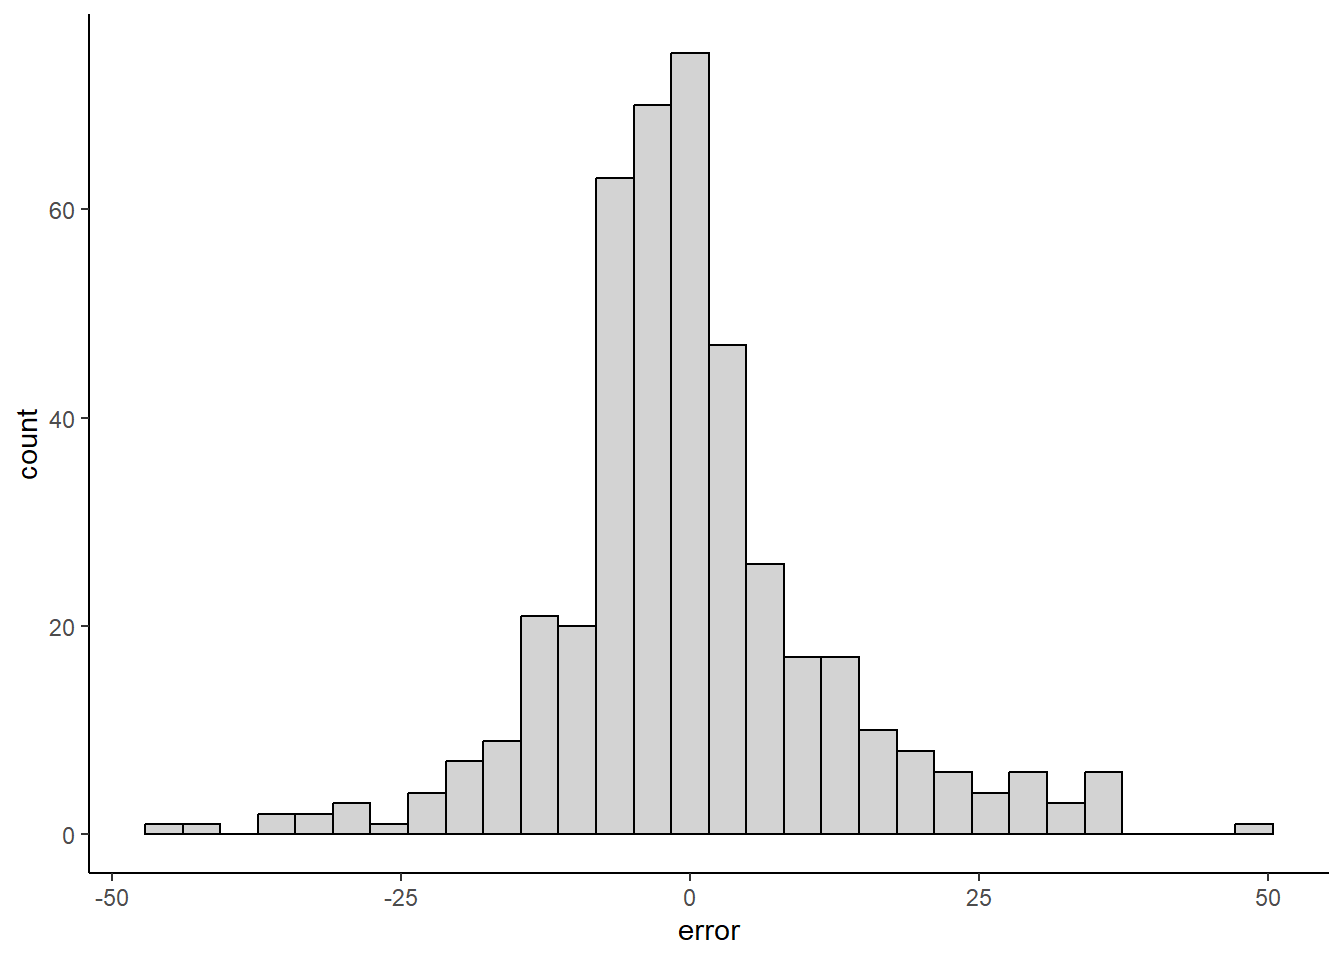

In [ ]:
model_patient_prim <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                             (1 + time_c | study_id), 
                           data = subset(data, dyad == "Patient"))

tibble(error = residuals(model_patient_prim)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates (We will only include covariates that significantly predict the outcome).

`race_white_only` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + race_white_only + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("race_white_onlyYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 -0.26 
 -8.95 – 8.43 
 0.953 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.282 / 0.765

`age_c` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + age_c + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("age_c"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 0.12 
 -0.18 – 0.42 
 0.422 
 

 
 N study_id 
 156 
 
 Observations 
 424 
 
 
 Marginal R 2 / Conditional R 2 
 0.285 / 0.761

`edu_c` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + edu_c + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("edu_c"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -0.46 
 -4.08 – 3.16 
 0.803 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.283 / 0.765

`meetings_yn` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + meetings_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("meetings_ynYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 -6.54 
 -13.30 – 0.22 
 0.058 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.267 / 0.749

`outpatient_yn_ever` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + outpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("outpatient_yn_everYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 -7.44 
 -15.72 – 0.84 
 0.078 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.284 / 0.764

`er_yn_ever` - **significant**

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + er_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("er_yn_everYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 -10.40 
 -18.85 – -1.95 
 0.016 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.284 / 0.761

`mat_yn` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + mat_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("mat_ynYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 1.49 
 -6.36 – 9.34 
 0.709 
 

 
 N study_id 
 158 
 
 Observations 
 410 
 
 
 Marginal R 2 / Conditional R 2 
 0.259 / 0.751

`inpatient_yn_ever` - **significant**

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + inpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("inpatient_yn_everYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 -10.03 
 -19.83 – -0.24 
 0.045 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.282 / 0.764

`other_psych_treatment_yn` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + other_psych_treatment_yn + 
       (1 + time_c | study_id), data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_psych_treatment_ynYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 1.20 
 -5.23 – 7.63 
 0.713 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.259 / 0.753

`other_medications_yn` - not significant

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + other_medications_yn + 
       (1 + time_c | study_id), data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_medications_ynYes"))


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 -3.36 
 -9.56 – 2.84 
 0.287 
 

 
 N study_id 
 158 
 
 Observations 
 409 
 
 
 Marginal R 2 / Conditional R 2 
 0.261 / 0.754

##### Final Model with Significant Covariates

In [ ]:
lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + inpatient_yn_ever + 
       er_yn_ever + (1 + time_c | study_id), 
     data = subset(data, dyad ==  "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F)


per heavy drink days 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 27.91 
 23.34 – 32.47 
 <0.001 
 
 
 time c 
 -5.11 
 -7.65 – -2.57 
 <0.001 
 
 
 arm cfam and achess vs C 
 -2.50 
 -10.47 – 5.47 
 0.538 
 
 
 arm cachess vs fam 
 4.81 
 -4.42 – 14.04 
 0.307 
 
 
 hdd 0 
 0.47 
 0.36 – 0.57 
 <0.001 
 
 
 inpatient yn ever [Yes] 
 -7.22 
 -17.39 – 2.96 
 0.164 
 
 
 er yn ever [Yes] 
 -8.59 
 -17.47 – 0.28 
 0.058 
 
 
 time c × arm cfam and achess vs C 
 -6.72 
 -12.06 – -1.38 
 0.014 
 
 
 time c × arm cachess vs fam 
 2.32 
 -3.96 – 8.60 
 0.469 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.288 / 0.761

#### Primary Partner Outcome: `oq45_scored`

Distribution of residuals  
*KW: Looks fine*

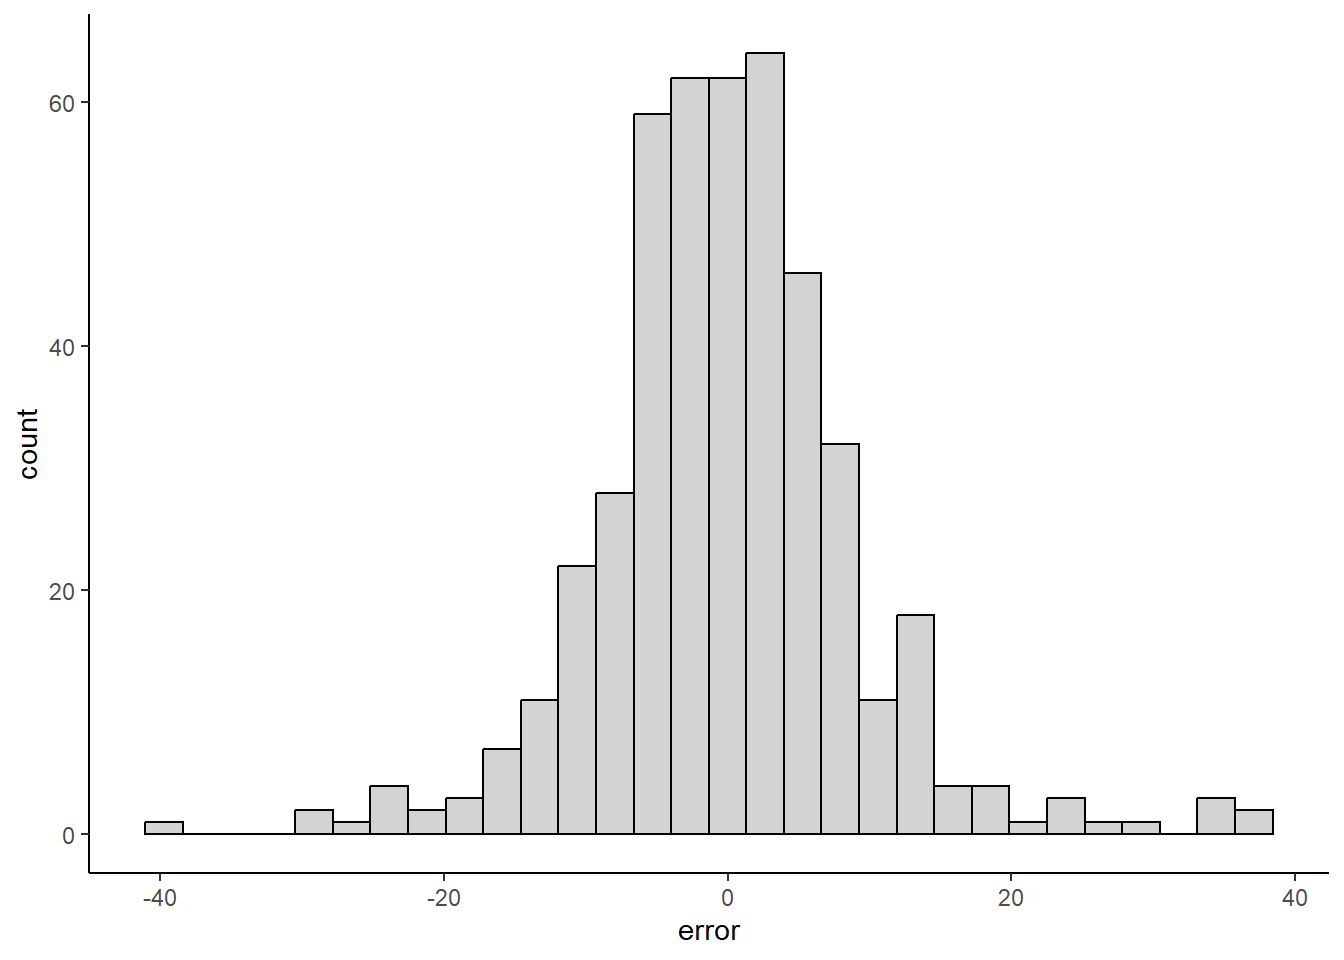

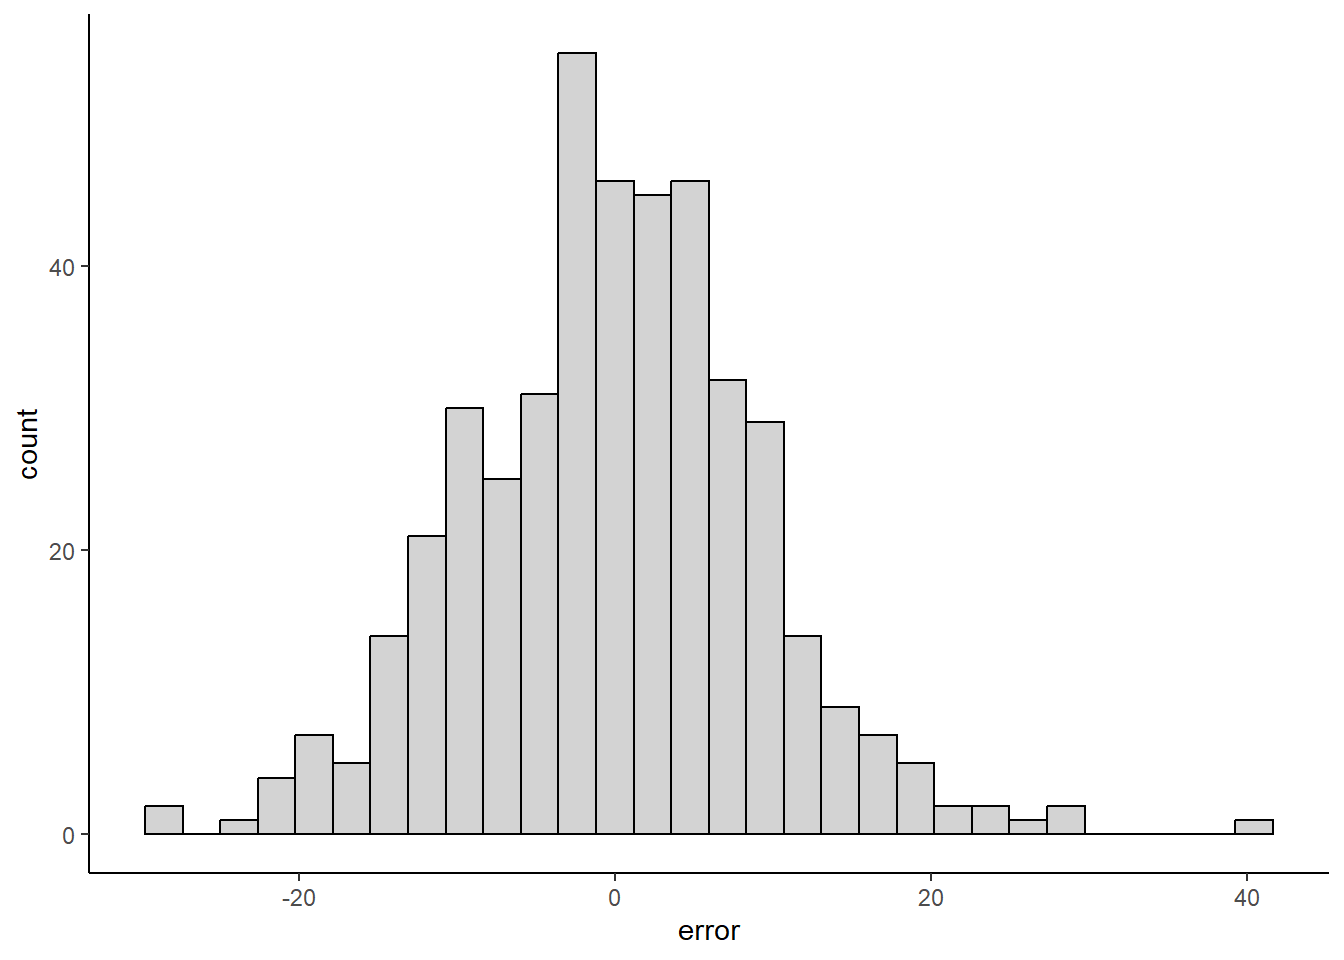

In [ ]:
model_partner_prim <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                             (1 + time_c | study_id), 
                           data = subset(data, dyad == "Partner"))

tibble(error = residuals(model_partner_prim)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates (We will only include covariates that significantly predict the outcome).

*Checking for sig covariates for partner and patient dyads*

`race_white_only` - not significant

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + race_white_only +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("race_white_onlyYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 -1.69 
 -6.98 – 3.60 
 0.531 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.475 / 0.776

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 0.19 
 -5.59 – 5.97 
 0.949 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.436 / 0.803

`age_c` - not significant

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + age_c + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("age_c"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 0.00 
 -0.15 – 0.16 
 0.969 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.474 / 0.776

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 0.10 
 -0.11 – 0.30 
 0.350 
 

 
 N study_id 
 167 
 
 Observations 
 433 
 
 
 Marginal R 2 / Conditional R 2 
 0.440 / 0.801

`edu_c` - **significant for partner but not patient**

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + edu_c + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("edu_c"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -2.46 
 -4.55 – -0.37 
 0.021 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.486 / 0.777

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -1.13 
 -3.46 – 1.20 
 0.342 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.439 / 0.803

`meetings_yn` - not significant

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + meetings_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("meetings_ynYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 0.21 
 -4.81 – 5.23 
 0.936 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.474 / 0.775

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 -0.69 
 -5.12 – 3.75 
 0.761 
 

 
 N study_id 
 167 
 
 Observations 
 435 
 
 
 Marginal R 2 / Conditional R 2 
 0.436 / 0.800

`outpatient_yn_ever` - **significant for partner** Not significant for patient

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + outpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("outpatient_yn_everYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 9.99 
 0.57 – 19.41 
 0.038 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.482 / 0.776

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 1.39 
 -4.13 – 6.91 
 0.621 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.437 / 0.803

`er_yn_ever` - Not significant

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + er_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("er_yn_everYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 3.79 
 -2.02 – 9.61 
 0.200 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.477 / 0.776

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 3.12 
 -2.71 – 8.95 
 0.294 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.439 / 0.804

`mat_yn` - not significant for partner, **significant for patient**

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + mat_yn + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("mat_ynYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 9.22 
 -0.20 – 18.63 
 0.055 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.479 / 0.778

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 6.86 
 2.05 – 11.68 
 0.005 
 

 
 N study_id 
 167 
 
 Observations 
 432 
 
 
 Marginal R 2 / Conditional R 2 
 0.445 / 0.808

`inpatient_yn_ever` - not significant

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + inpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("inpatient_yn_everYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 11.49 
 -3.59 – 26.57 
 0.135 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.478 / 0.776

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 3.73 
 -2.93 – 10.39 
 0.272 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.438 / 0.803

`other_psych_treatment_yn` - **significant for partner** not significant for patient

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + other_psych_treatment_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_psych_treatment_ynYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 5.33 
 0.23 – 10.43 
 0.041 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.481 / 0.770

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 -0.61 
 -4.72 – 3.51 
 0.772 
 

 
 N study_id 
 167 
 
 Observations 
 435 
 
 
 Marginal R 2 / Conditional R 2 
 0.435 / 0.802

`other_medications_yn` - **significant for partner** not significant for patient

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + other_medications_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_medications_ynYes"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 6.02 
 1.88 – 10.15 
 0.004 
 

 
 N study_id 
 170 
 
 Observations 
 452 
 
 
 Marginal R 2 / Conditional R 2 
 0.491 / 0.769

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 3.09 
 -0.92 – 7.10 
 0.131 
 

 
 N study_id 
 167 
 
 Observations 
 431 
 
 
 Marginal R 2 / Conditional R 2 
 0.442 / 0.799

##### Final Model with Significant Covariates

In [ ]:
lmer(oq45_scored ~ time_c*arm_c + oq45_0 + edu_c + outpatient_yn_ever + 
       other_psych_treatment_yn + other_medications_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F)


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 54.09 
 51.32 – 56.86 
 <0.001 
 
 
 time c 
 -0.86 
 -2.24 – 0.52 
 0.222 
 
 
 arm cfam and achess vs C 
 -2.48 
 -7.07 – 2.10 
 0.287 
 
 
 arm cachess vs fam 
 -1.05 
 -6.26 – 4.17 
 0.693 
 
 
 oq45 0 
 0.71 
 0.61 – 0.81 
 <0.001 
 
 
 edu c 
 -2.34 
 -4.38 – -0.30 
 0.025 
 
 
 outpatient yn ever [Yes] 
 8.18 
 -0.97 – 17.34 
 0.080 
 
 
 other psych treatment yn [Yes] 
 3.72 
 -1.43 – 8.87 
 0.156 
 
 
 other medications yn [Yes] 
 5.35 
 1.18 – 9.53 
 0.012 
 
 
 time c × arm cfam and achess vs C 
 -1.55 
 -4.53 – 1.43 
 0.308 
 
 
 time c × arm cachess vs fam 
 0.75 
 -2.56 – 4.07 
 0.655 
 

 
 N study_id 
 170 
 
 Observations 
 452 
 
 
 Marginal R 2 / Conditional R 2 
 0.508 / 0.767

oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 53.80 
 50.92 – 56.68 
 <0.001 
 
 
 time c 
 -3.35 
 -4.93 – -1.77 
 <0.001 
 
 
 arm cfam and achess vs C 
 -7.11 
 -12.70 – -1.52 
 0.013 
 
 
 arm cachess vs fam 
 0.25 
 -6.11 – 6.61 
 0.939 
 
 
 oq45 0 
 0.69 
 0.58 – 0.79 
 <0.001 
 
 
 mat yn [Yes] 
 6.86 
 2.05 – 11.68 
 0.005 
 
 
 time c × arm cfam and achess vs C 
 -0.24 
 -3.56 – 3.08 
 0.887 
 
 
 time c × arm cachess vs fam 
 -1.07 
 -4.97 – 2.83 
 0.590 
 

 
 N study_id 
 167 
 
 Observations 
 432 
 
 
 Marginal R 2 / Conditional R 2 
 0.445 / 0.808

#### Secondary Patient Outcome: `per_days_abstinent`

Distribution of residuals  
*Looks fine*

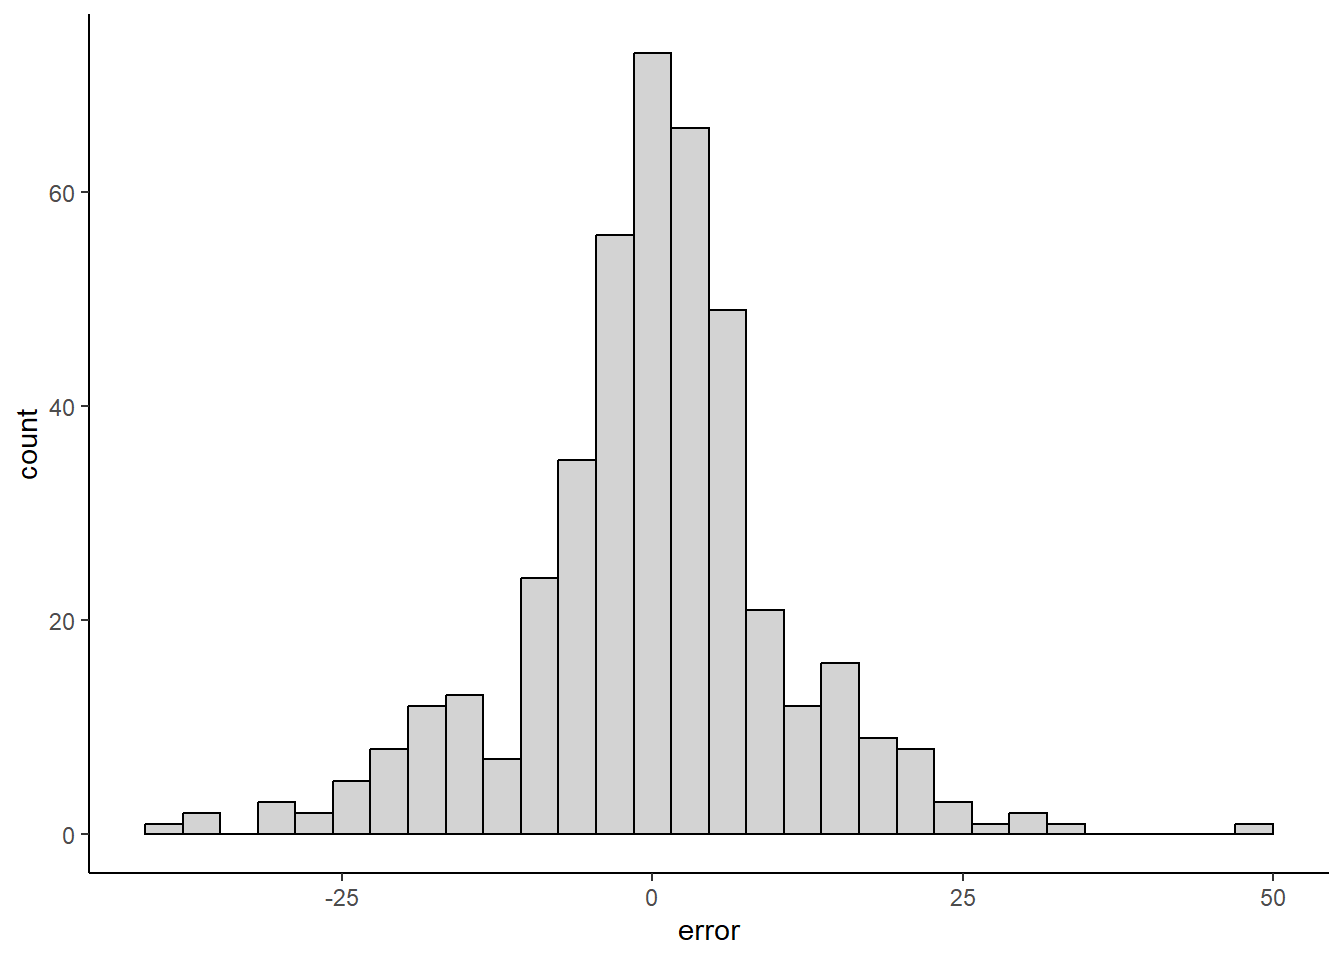

In [ ]:
model_patient_sec <- lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + 
                             (1 + time_c | study_id), 
                          data = subset(data, dyad == "Patient"))

tibble(error = residuals(model_patient_sec)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates

`race_white_only` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + race_white_only + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("race_white_onlyYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 5.79 
 -3.72 – 15.30 
 0.232 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.367 / 0.845

`age_c` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + age_c + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("age_c"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 -0.25 
 -0.59 – 0.08 
 0.133 
 

 
 N study_id 
 156 
 
 Observations 
 424 
 
 
 Marginal R 2 / Conditional R 2 
 0.368 / 0.842

`edu_c` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + edu_c + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("edu_c"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -0.56 
 -4.40 – 3.27 
 0.773 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.362 / 0.844

`meetings_yn` - **significant**

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + meetings_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("meetings_ynYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 9.85 
 3.10 – 16.59 
 0.004 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.358 / 0.847

`outpatient_yn_ever` - **significant**

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + outpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("outpatient_yn_everYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 9.97 
 0.86 – 19.08 
 0.032 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.364 / 0.844

`er_yn_ever` - Not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + er_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("er_yn_everYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 8.07 
 -1.33 – 17.46 
 0.092 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.355 / 0.843

`mat_yn` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + mat_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |>  
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("mat_ynYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 -4.04 
 -11.86 – 3.79 
 0.311 
 

 
 N study_id 
 158 
 
 Observations 
 410 
 
 
 Marginal R 2 / Conditional R 2 
 0.342 / 0.838

`inpatient_yn_ever` - **significant**

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + inpatient_yn_ever + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("inpatient_yn_everYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 12.24 
 1.42 – 23.06 
 0.027 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.363 / 0.844

`other_psych_treatment_yn` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + other_psych_treatment_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_psych_treatment_ynYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 2.47 
 -3.83 – 8.78 
 0.441 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.346 / 0.840

`other_medications_yn` - not significant

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + other_medications_yn + 
       (1 + time_c | study_id), data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_medications_ynYes"))


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 0.09 
 -6.15 – 6.33 
 0.978 
 

 
 N study_id 
 158 
 
 Observations 
 409 
 
 
 Marginal R 2 / Conditional R 2 
 0.342 / 0.837

##### Final Model with Significant Covariates

In [ ]:
lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + outpatient_yn_ever + 
       meetings_yn + inpatient_yn_ever + (1 + time_c | study_id), 
     data = subset(data, dyad == "Patient")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F)


per days abstinent 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 56.49 
 51.39 – 61.59 
 <0.001 
 
 
 time c 
 5.93 
 3.46 – 8.39 
 <0.001 
 
 
 arm cfam and achess vs C 
 1.41 
 -7.44 – 10.26 
 0.755 
 
 
 arm cachess vs fam 
 -4.78 
 -15.04 – 5.48 
 0.361 
 
 
 pda 0 
 0.60 
 0.48 – 0.73 
 <0.001 
 
 
 outpatient yn ever [Yes] 
 4.57 
 -6.10 – 15.25 
 0.400 
 
 
 meetings yn [Yes] 
 8.22 
 1.28 – 15.16 
 0.020 
 
 
 inpatient yn ever [Yes] 
 8.45 
 -3.99 – 20.89 
 0.182 
 
 
 time c × arm cfam and achess vs C 
 5.14 
 -0.01 – 10.29 
 0.050 
 
 
 time c × arm cachess vs fam 
 -0.30 
 -6.44 – 5.83 
 0.923 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.370 / 0.846

#### Secondary Partner Outcome 1: `relationsatisf_scored`

Distribution of residuals

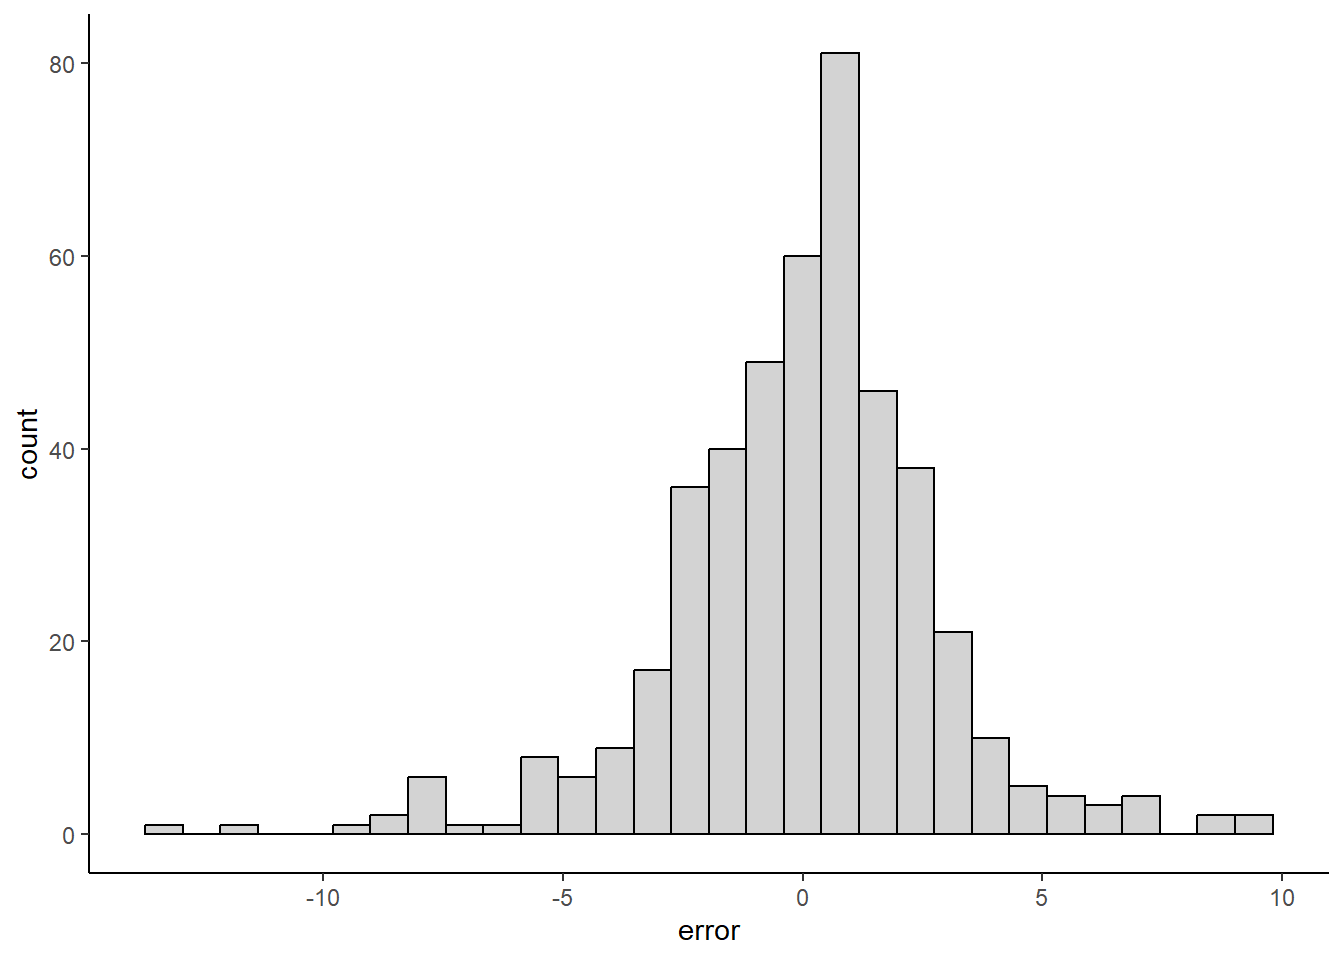

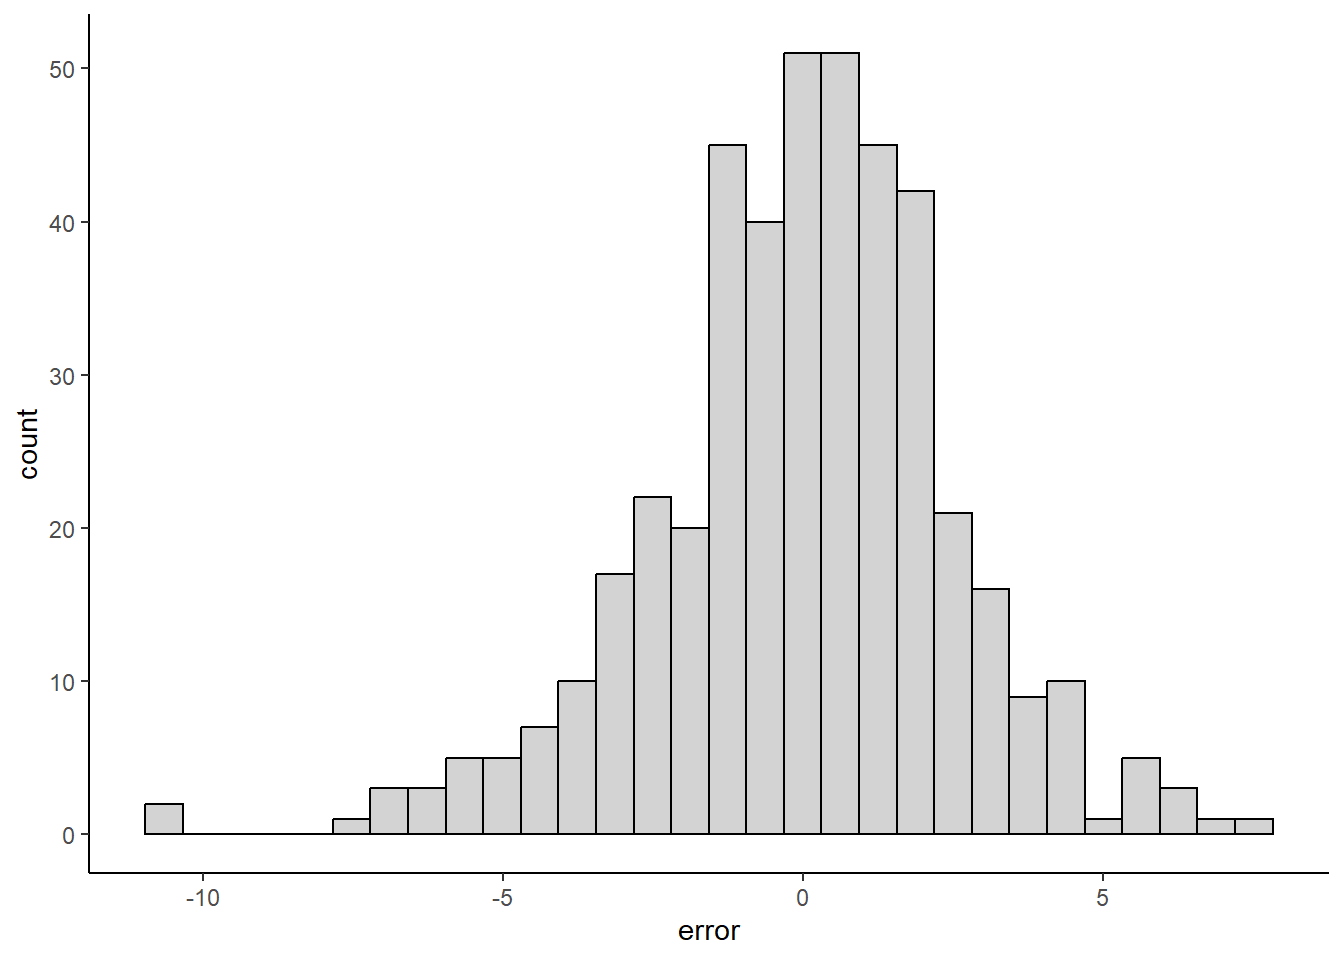

In [ ]:
model_partner_sec_1 <- lmer(relationsatisf_scored ~ time_c*arm_c + 
                              relationsatisf_0 + (1 + time_c | study_id), 
                            data = subset(data, dyad == "Partner"))

tibble(error = residuals(model_partner_sec_1)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates

`race_white_only` - not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + race_white_only +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("race_white_onlyYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 0.45 
 -1.14 – 2.04 
 0.578 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.390 / 0.729

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only [Yes] 
 0.45 
 -1.03 – 1.93 
 0.552 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.307 / 0.726

`age_c` - not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + age_c +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("age_c"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 -0.02 
 -0.06 – 0.03 
 0.433 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.391 / 0.729

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 age c 
 -0.04 
 -0.09 – 0.02 
 0.173 
 

 
 N study_id 
 167 
 
 Observations 
 433 
 
 
 Marginal R 2 / Conditional R 2 
 0.320 / 0.739

`edu_c` - not significant for partner, **significant for patient**

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + edu_c +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("edu_c"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 0.37 
 -0.26 – 0.99 
 0.254 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.393 / 0.729

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 0.61 
 0.03 – 1.20 
 0.040 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.318 / 0.723

`meetings_yn` - not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + meetings_yn +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("meetings_ynYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 -0.60 
 -2.16 – 0.97 
 0.453 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.390 / 0.729

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn [Yes] 
 0.52 
 -0.64 – 1.69 
 0.379 
 

 
 N study_id 
 167 
 
 Observations 
 435 
 
 
 Marginal R 2 / Conditional R 2 
 0.306 / 0.728

`outpatient_yn_ever` - Not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
       outpatient_yn_ever + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("outpatient_yn_everYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 -0.62 
 -3.51 – 2.26 
 0.672 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.390 / 0.729

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 outpatient yn ever [Yes] 
 -0.76 
 -2.18 – 0.67 
 0.298 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.310 / 0.725

`er_yn_ever` - Not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + er_yn_ever +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("er_yn_everYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 0.81 
 -0.93 – 2.56 
 0.360 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.392 / 0.730

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 er yn ever [Yes] 
 -1.29 
 -2.74 – 0.16 
 0.082 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.315 / 0.725

`mat_yn` - not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + mat_yn +
       (1 + time_c | study_id), data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, terms = c("mat_ynYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 1.27 
 -1.61 – 4.15 
 0.387 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.391 / 0.728

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn [Yes] 
 0.24 
 -1.04 – 1.52 
 0.713 
 

 
 N study_id 
 167 
 
 Observations 
 432 
 
 
 Marginal R 2 / Conditional R 2 
 0.300 / 0.736

`inpatient_yn_ever` - **significant for partner** not significant for patient

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
       inpatient_yn_ever + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("inpatient_yn_everYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 -7.23 
 -11.61 – -2.84 
 0.001 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.413 / 0.727

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 inpatient yn ever [Yes] 
 -1.06 
 -2.74 – 0.61 
 0.212 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.311 / 0.726

`other_psych_treatment_yn` - not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
       other_psych_treatment_yn + (1 + time_c | study_id),
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_psych_treatment_ynYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 -1.16 
 -2.76 – 0.45 
 0.157 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.393 / 0.727

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn [Yes] 
 -0.41 
 -1.51 – 0.70 
 0.472 
 

 
 N study_id 
 167 
 
 Observations 
 435 
 
 
 Marginal R 2 / Conditional R 2 
 0.307 / 0.727

`other_medications_yn` - Not significant

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
       other_medications_yn + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F, 
                    terms = c("other_medications_ynYes"))


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 -0.28 
 -1.55 – 0.99 
 0.667 
 

 
 N study_id 
 170 
 
 Observations 
 452 
 
 
 Marginal R 2 / Conditional R 2 
 0.391 / 0.725

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other medications yn [Yes] 
 0.08 
 -0.98 – 1.14 
 0.882 
 

 
 N study_id 
 167 
 
 Observations 
 431 
 
 
 Marginal R 2 / Conditional R 2 
 0.303 / 0.733

##### Final Model with Significant Covariates

In [ ]:
lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
       inpatient_yn_ever + (1 + time_c | study_id), 
     data = subset(data, dyad == "Partner")) |> 
  sjPlot::tab_model(show.re.var = F, show.icc = F)


relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 22.07 
 21.43 – 22.72 
 <0.001 
 
 
 time c 
 0.10 
 -0.36 – 0.57 
 0.664 
 
 
 arm cfam and achess vs C 
 -0.53 
 -1.90 – 0.85 
 0.451 
 
 
 arm cachess vs fam 
 -0.21 
 -1.75 – 1.34 
 0.793 
 
 
 relationsatisf 0 
 0.86 
 0.74 – 0.99 
 <0.001 
 
 
 inpatient yn ever [Yes] 
 -7.23 
 -11.61 – -2.84 
 0.001 
 
 
 time c × arm cfam and achess vs C 
 -0.09 
 -1.10 – 0.92 
 0.858 
 
 
 time c × arm cachess vs fam 
 0.70 
 -0.43 – 1.82 
 0.224 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.413 / 0.727

relationsatisf scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 21.41 
 20.76 – 22.06 
 <0.001 
 
 
 time c 
 -0.12 
 -0.53 – 0.29 
 0.573 
 
 
 arm cfam and achess vs C 
 -0.36 
 -1.75 – 1.02 
 0.606 
 
 
 arm cachess vs fam 
 1.31 
 -0.26 – 2.89 
 0.102 
 
 
 relationsatisf 0 
 0.68 
 0.55 – 0.81 
 <0.001 
 
 
 edu c 
 0.61 
 0.03 – 1.20 
 0.040 
 
 
 time c × arm cfam and achess vs C 
 -0.52 
 -1.38 – 0.35 
 0.243 
 
 
 time c × arm cachess vs fam 
 0.61 
 -0.40 – 1.62 
 0.238 
 

 
 N study_id 
 168 
 
 Observations 
 436 
 
 
 Marginal R 2 / Conditional R 2 
 0.318 / 0.723

#### Secondary Partner Outcome 2: `abuse_scored`

### Check Assumptions for Analyses of Mediators

**KW: mediators only for primary outcomes and ACHESS vs. FamCHESS contrasts**

List of Patient mediators: `socrates_scored`  
List of Partner mediators: `peersupport_scored`, `treatmentskills_scored`

### Check Assumptions for Analyses of Moderators

**KW: moderators only for primary outcomes**

List of Patient moderators: `dsm5_criteria`  
List of Partner moderators: `gender`, `days_app_use`